# Фотометрия

Ноутбук с функциями для работы с фотометрией.

In [1]:
from IPython.display import Image
import numpy as np
import math

%pylab
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


## Калибровки Bell et al. 2003

Калибровки Bell et al. (2003) https://ui.adsabs.harvard.edu/#abs/2003ApJS..149..289B/abstract

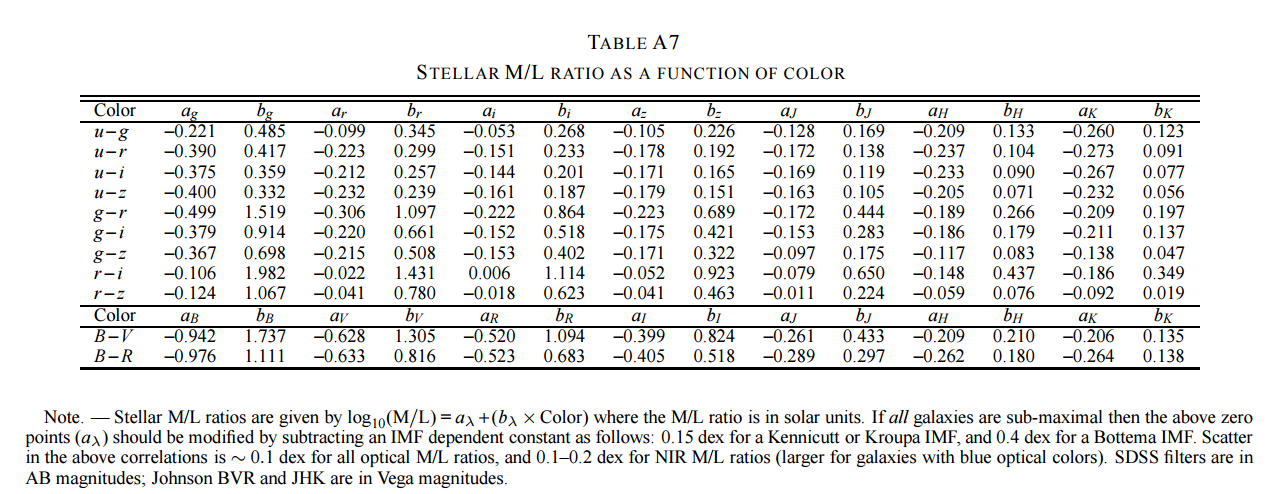

In [2]:
Image('../Bell_2003.png')

$$\log_{10}(M/L)=a_{\lambda} + b_{\lambda}\times Color$$

In [3]:
def bell_mass_to_light(color, band, color_str):
    '''Отношение масса светимость вычисляется по калибровке из статьи Bell E. 2003 Table7.'''
    coeffs = {'B-V' : {'B' : [-0.942, 1.737], 'V' : [-0.628, 1.305], 'R' : [-0.520, 1.094], 
                       'I' : [-0.399, 0.824], 'J' : [-0.261, 0.433], 'H' : [-0.209, 0.210], 'K' : [-0.206, 0.135]},
             'B-R' : {'B' : [-0.976, 1.111], 'V' : [-0.633, 0.816], 'R' : [-0.523, 0.683], 
                      'I' : [-0.405, 0.518], 'J' : [-0.289, 0.297], 'H' : [-0.262, 0.180], 'K' : [-0.264, 0.138]}}
    a = coeffs[color_str][band][0]
    b = coeffs[color_str][band][1]
    return np.power(10, a + b * color)

Абсолютная величина Солнца в нескольких полосах отсюда http://www.ucolick.org/~cnaw/sun.html (на самом деле из Binney and Merrifield 1998, Galactic Astronomy, Table 2.1 (page 53)):

In [4]:
sun_abs_mags = {'U' : 5.61,
                'B' : 5.48,
                'V' : 4.83,
                'R' : 4.42,
                'I' : 4.08,
                'J' : 3.64,
                'H' : 3.32,
                'K' : 3.28}

In [5]:
def surface_brightness(mu=None, band=None):
    '''Пересчет поверхностной яркости из mag/arcsec^2 в Lsun/pc^2 по формуле
    http://www.astro.spbu.ru/staff/resh/Books/SurfPhot/node3.html#sec1.1'''
    sun_mag = sun_abs_mags[band]
    return 4.255 * math.pow(10, 8 + 0.4 * (sun_mag - mu))

## Компоненты галактики 
Диск:
$$I_d(r) = I_{0,d}\exp{-\frac{r}{h}}$$ или $$\mu_d(r) = \mu_{0,d} + 1.0857\frac{r}{h}$$
Балдж:
$$I_b(r) = I_e\exp\large[-b_n\large[{(\frac{r}{r_e})}^{\frac{1}{n}}-1 \large] \large]$$ $I_e = I_{0,b}\exp{b_n}$ $$\mu_b(r) = \mu_{e} + 1.0857b_n\large[{(\frac{r}{r_e})}^{\frac{1}{n}}-1 \large]$$

Или в другом виде:
$$\mu_b(r) = \mu_{0} + \frac{2.5\nu_n}{\log 10}(\frac{r}{r_e})^{\frac{1}{n}}$$ где приближенно $\nu_n = 2n - \frac{1}{3} + \frac{4}{405n} = \frac{46}{25515n^2} + O(n^{-3})$ (из Решетникова http://www.astro.spbu.ru/staff/resh/Books/SurfPhot/node14.html). Отметим, что в формуле выше $\mu_e$, a ниже $\mu_0$ - надо аккуратно за этим следить ($\mu_e = \mu_0 + 2.5\nu_n/\log 10$).

In [6]:
#TODO: добавить ссылку
def mu_bulge(r, mu_eff=None, r_eff=None, n=None):
    '''поверхностная яркость балджа с квадр. угл. секунды
    параметры - эфф. яркость, эфф. радиус, параметр Серсика, расстояние'''
    bn = 1.9992*n - 0.3271
    return mu_eff + 1.0857*bn*((r/r_eff)**(1./n) - 1)

In [7]:
def mu_bulge2(r, mu_eff=None, r_eff=None, n=None):
    '''второй вариант формулы для поверхностной яркости балджа с квадр. угл. секунды
    параметры те же'''
    nu_n = 2*n - 1./3  + 4./(405*n) + 46./(25515*n**2)
    return mu_eff + (2.5*nu_n/np.log(10))*((r/r_eff)**(1./n) - 1)

In [8]:
def mu_disc(r, mu0=None, h=None):
    '''поверхностная яркость для диска'''
    return mu0 + 1.0857*r/h

In [9]:
def total_mu_profile(*args):
    '''Пересчет суммарного профиля яркости в звездных величинах для нескольких компонент, например disc+bulge
    или disc1+ disc2. Важно, что они должны быть из одной полосы.'''
    points = len(args[0])
    sum_brightness = np.zeros(points)
    for arg in args:
        sum_brightness += np.power(10, -np.array(arg)/2.5)
    return -2.5*np.log10(sum_brightness)

In [10]:
def surf_density(mu=None, M_to_L=None, band=None):
    '''Плотность для любого компонента галактики - пересчитываем mu в яркость и домножаем на M/L'''
    return M_to_L*surface_brightness(mu=mu, band=band)